# Predicting Length of Stay (LOS)

### How long will a patient stay hospitalized?

This task covers the clinical problem of forecast `length of stay (LOS)`. Length of Stay is defined as the time between hospital admission and discharge measured in days. It is a key performance indicator that can provide insights from cost analysis to patient outcomes. 

This notebook derived from publicly available intensive care medical information market (MIMIC-III) database to explore supervised statistical learning models to predict LOS.
Accurate prediction of LOS is important for scheduling and hospital resource management.

MIMIC-III is a relational database consisting of 26 tables.
After reviewing the contents of each table in the MIMIC database, We finally selected the following tables and interpreted them using Pandas: `ADMISSIONS.csv`, `PATIENTS.csv`, `ICUSTAYS.csv`, `SERVICES.csv`, `TRANSFERS.csv`, `CALLOUT.csv`, `CPTEVENTS.csv`, `INPUTEVENTS_CV.csv`, `MICROBIOLOGYEVENTS.csv`, `PRESCRIPTIONS.csv`, `DIAGNOSES_ICD.csv`, `OUTPUTEVENTS.csv`

## 1. Data preparation, Data cleaning and Exploratory Data Analysis

### 1.1 Data Preparation

In [2]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, classification_report,confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVR, SVC
from tensorflow.keras.constraints import max_norm
from sklearn.naive_bayes import GaussianNB
from sklearn import linear_model
import statsmodels.api as sm

# tensorflow
import tensorflow as tf
from tensorflow.keras import models, regularizers, layers, optimizers, losses, metrics
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, SpatialDropout1D
from tensorflow.keras.utils import to_categorical
from keras import backend as K

import pickle

Using TensorFlow backend.


Five tables are used to define and track patient stays: `ADMISSIONS; PATIENTS; ICUSTAYS; SERVICES; and TRANSFERS`. The remaining tables contain data associated with dictionaries for cross-referencing codes against their respective definitions, patient care, such as physiological measurements, caregiver observations, and billing information.

 SUBJECT_ID refers to a unique patient, HADM_ID refers to a unique admission to the hospital, and ICUSTAY_ID refers to a unique admission to an intensive care unit.

In [0]:
# Data
df_adm = pd.read_csv('data/ADMISSIONS.csv')
df_pat = pd.read_csv('data/PATIENTS.csv')
df_icu = pd.read_csv('data/ICUSTAYS.csv')
df_ser = pd.read_csv('data/SERVICES.csv')
df_tran = pd.read_csv('data/TRANSFERS.csv')

df_call = pd.read_csv('data/CALLOUT.csv')
df_cpt = pd.read_csv('data/CPTEVENTS.csv')
df_inputcv = pd.read_csv('data/INPUTEVENTS_CV.csv')
df_MICROBIO = pd.read_csv('data/MICROBIOLOGYEVENTS.csv')
df_drug = pd.read_csv('data/PRESCRIPTIONS.csv')
df_diag = pd.read_csv('data/DIAGNOSES_ICD.csv')
df_out = pd.read_csv('data/OUTPUTEVENTS.csv')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (4,5,7,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (7,9,17,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


`ADMISSIONS.csv`

In [0]:
# select meaningful columns
df_adm = df_adm[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME',  'DEATHTIME',
                'INSURANCE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY']]

In [0]:
# remove patient who resulting in death
df_adm = df_adm[df_adm['DEATHTIME'].isnull()]

In [0]:
df_adm.drop(['DEATHTIME'], axis=1, inplace=True)

In [0]:
df_adm['ADMITTIME'] = pd.to_datetime(df_adm['ADMITTIME'])
df_adm['DISCHTIME'] = pd.to_datetime(df_adm['DISCHTIME'])
# Define Length of Stay
df_adm['LOS'] = (df_adm['DISCHTIME'] - df_adm['ADMITTIME']).dt.days

In [0]:
# remove negative values
df_adm = df_adm[df_adm['LOS'] > 0]

In [0]:
df_adm['LOS'].describe()

count    51801.000000
mean         9.854964
std         12.337576
min          1.000000
25%          3.000000
50%          6.000000
75%         11.000000
max        294.000000
Name: LOS, dtype: float64

In [0]:
mean_los = df_adm['LOS'].mean()
median_los = df_adm['LOS'].median()
print(('Average Los is {:.0f} Days').format(mean_los))
print(('Median Los is {:.0f} Days').format(median_los))

Average Los is 10 Days
Median Los is 6 Days


In [0]:
df_adm['INSURANCE'].value_counts()

Medicare      23919
Private       20590
Medicaid       5209
Government     1634
Self Pay        449
Name: INSURANCE, dtype: int64

In [0]:
top_5_religions = df_adm['RELIGION'].value_counts()[:5].index.tolist()

df_adm['RELIGION'].loc[~df_adm['RELIGION'].isin(top_5_religions)] = 'OTHER'
df_adm['RELIGION'].value_counts()

CATHOLIC             18313
NOT SPECIFIED        10459
UNOBTAINABLE          6920
PROTESTANT QUAKER     6335
OTHER                 5207
JEWISH                4567
Name: RELIGION, dtype: int64

In [0]:
top_5_ethnicity = df_adm['ETHNICITY'].value_counts()[:5].index.tolist()
top_5_ethnicity 

df_adm['ETHNICITY'].loc[~df_adm['ETHNICITY'].isin(top_5_ethnicity)] = 'OTHER'
df_adm['ETHNICITY'].value_counts()

WHITE                     36048
BLACK/AFRICAN AMERICAN     4921
OTHER                      4227
UNKNOWN/NOT SPECIFIED      3693
HISPANIC OR LATINO         1541
ASIAN                      1371
Name: ETHNICITY, dtype: int64

In [0]:
df_adm.to_csv('newdata/df_adm.csv')

`PATIENTS.csv`

In [0]:
# DOB stands for date of birth
df_pat = df_pat[['SUBJECT_ID', 'GENDER', 'DOB']]

In [0]:
df_pat['DOB'] = pd.to_datetime(df_pat['DOB'])

In [0]:
df_pat = df_pat.merge(df_adm, on='SUBJECT_ID', how='inner')

In [0]:
# take the first admission time
df_pat_age = df_pat.groupby(['SUBJECT_ID', 'ADMITTIME'])['DOB'].first().reset_index()
df_pat_age.head()

,SUBJECT_ID,ADMITTIME,DOB
0,2,2138-07-17 19:04:00,2138-07-17
1,3,2101-10-20 19:08:00,2025-04-11
2,4,2191-03-16 00:28:00,2143-05-12
3,5,2103-02-02 04:31:00,2103-02-02
4,6,2175-05-30 07:15:00,2109-06-21


In [0]:
# calculate age for each patient
df_pat_age['ADMITTIME'] = pd.to_datetime(df_pat_age['ADMITTIME']).dt.date
df_pat_age['DOB'] = pd.to_datetime(df_pat_age['DOB']).dt.date
df_pat_age['AGE'] = df_pat_age['ADMITTIME']-df_pat_age['DOB']
df_pat_age['AGE'] = df_pat_age['AGE'].astype('timedelta64[D]').dt.days // 365
df_pat_age.loc[df_pat_age['AGE']<0]=90
df_pat_age = df_pat_age[['SUBJECT_ID', 'AGE']]
df_pat_age.head()

,SUBJECT_ID,AGE
0,2,0
1,3,76
2,4,47
3,5,0
4,6,65


In [0]:
df_pat = pd.merge(df_pat, df_pat_age, on=['SUBJECT_ID'], how='inner')

In [0]:
bins= [0,10,18,36,56,100]
labels = ['newborn','teens','young-adult','adult','senior']

df_pat['AgeGroup'] = pd.cut(df_pat['AGE'], bins=bins, labels=labels, right=False)

In [0]:
df_pat.head()

,SUBJECT_ID,GENDER,DOB,HADM_ID,ADMITTIME,DISCHTIME,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,LOS,AGE,AgeGroup
0,249,F,2075-03-13,116935,2149-12-17 20:41:00,2149-12-31 14:55:00,Medicare,CATHOLIC,DIVORCED,WHITE,13,74,senior
1,249,F,2075-03-13,116935,2149-12-17 20:41:00,2149-12-31 14:55:00,Medicare,CATHOLIC,DIVORCED,WHITE,13,79,senior
2,249,F,2075-03-13,116935,2149-12-17 20:41:00,2149-12-31 14:55:00,Medicare,CATHOLIC,DIVORCED,WHITE,13,81,senior
3,249,F,2075-03-13,149546,2155-02-03 20:16:00,2155-02-14 11:15:00,Medicare,CATHOLIC,DIVORCED,WHITE,10,74,senior
4,249,F,2075-03-13,149546,2155-02-03 20:16:00,2155-02-14 11:15:00,Medicare,CATHOLIC,DIVORCED,WHITE,10,79,senior


In [0]:
df_pat.to_csv('newdata/df_pat.csv')

In [0]:
df = df_pat.drop('AGE', axis = 1)

`ICUSTAYS.csv`

In [0]:
df_icu = pd.read_csv('data/ICUSTAYS.csv')

In [0]:
df_icu = df_icu[['SUBJECT_ID', 'HADM_ID', 'FIRST_CAREUNIT']]

In [0]:
# change different types of ICUs to ICU
df_icu['FIRST_CAREUNIT'] = df_icu['FIRST_CAREUNIT'].replace({'MICU': 'ICU', 'CSRU': 'ICU', 
                                                            'SICU': 'ICU', 'CCU': 'ICU', 'TSICU': 'ICU'})
df_icu['FIRST_CAREUNIT'].value_counts()

ICU     53432
NICU     8100
Name: FIRST_CAREUNIT, dtype: int64

In [0]:
df_icu = df_icu.merge(df, on=['SUBJECT_ID', 'HADM_ID'], how='inner')

In [0]:
df_icu = df_icu.rename(columns={'FIRST_CAREUNIT':'CAREUNIT'})

In [0]:
df_icu.to_csv('newdata/df_icu.csv')

In [0]:
df = df_icu.copy()

`SERVICES.csv`

In [0]:
df_ser = pd.read_csv('data/SERVICES.csv')

In [0]:
service = df_ser.groupby(['SUBJECT_ID', 'HADM_ID'])['TRANSFERTIME'].count().reset_index()

In [0]:
df_ser['CURR_SERVICE'].value_counts()

MED      24866
CMED      9135
CSURG     7911
NB        7806
SURG      5514
NSURG     4100
TRAUM     3137
NMED      2957
OMED      2286
VSURG     1455
TSURG     1338
ORTHO     1101
GU         436
NBB        346
GYN        306
PSURG      283
ENT        247
OBS        113
DENT         5
PSYCH        1
Name: CURR_SERVICE, dtype: int64

In [0]:
top_10_services = df_ser['CURR_SERVICE'].value_counts()[:10].index.tolist()

df_ser['CURR_SERVICE'].loc[~df_ser['CURR_SERVICE'].isin(top_10_services)] = 'OTHER'
df_ser['CURR_SERVICE'].value_counts()

MED      24866
CMED      9135
CSURG     7911
NB        7806
SURG      5514
OTHER     4176
NSURG     4100
TRAUM     3137
NMED      2957
OMED      2286
VSURG     1455
Name: CURR_SERVICE, dtype: int64

In [0]:
curr = df_ser[['SUBJECT_ID', 'HADM_ID','CURR_SERVICE']]

In [0]:
df_ser = service.merge(curr, on=['SUBJECT_ID', 'HADM_ID'], how='inner')

In [0]:
df_ser = df_ser.merge(df, on=['SUBJECT_ID', 'HADM_ID'], how='inner')

In [0]:
df_ser = df_ser.rename(columns={'CURR_SERVICE':'SERVICE'})

In [0]:
df = df_ser.copy()

`TRANSFERS.csv`

In [0]:
df_tran = pd.read_csv('data/TRANSFERS.csv')

In [0]:
df_tran = df_tran[['SUBJECT_ID', 'HADM_ID', 'DBSOURCE', 'EVENTTYPE']]

In [0]:
df_tran['DBSOURCE'].loc[df_tran['DBSOURCE'] == 'both'] = 'carevue & metavision'

In [0]:
df_tran['EVENTTYPE'].value_counts()

transfer     144045
discharge     58919
admit         58909
Name: EVENTTYPE, dtype: int64

In [0]:
df_tran = df_tran.merge(df, on=['SUBJECT_ID', 'HADM_ID'], how='inner')

In [0]:
df = df_tran.copy()

`CALLOUT.csv`

In [0]:
df_call.columns

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'SUBMIT_WARDID', 'SUBMIT_CAREUNIT',
       'CURR_WARDID', 'CURR_CAREUNIT', 'CALLOUT_WARDID', 'CALLOUT_SERVICE',
       'REQUEST_TELE', 'REQUEST_RESP', 'REQUEST_CDIFF', 'REQUEST_MRSA',
       'REQUEST_VRE', 'CALLOUT_STATUS', 'CALLOUT_OUTCOME', 'DISCHARGE_WARDID',
       'ACKNOWLEDGE_STATUS', 'CREATETIME', 'UPDATETIME', 'ACKNOWLEDGETIME',
       'OUTCOMETIME', 'FIRSTRESERVATIONTIME', 'CURRENTRESERVATIONTIME'],
      dtype='object')

In [0]:
df_call = df_call[['SUBJECT_ID', 'HADM_ID', 'REQUEST_TELE', 'REQUEST_RESP', 'REQUEST_CDIFF', 'REQUEST_MRSA', 'REQUEST_VRE',]]

In [0]:
df_call = df_call.merge(df, on=['SUBJECT_ID', 'HADM_ID'], how='inner')

In [0]:
df = df_call.copy()

`CPTEVENTS.csv`

In [0]:
df_cpt = pd.read_csv('data/CPTEVENTS.csv')

In [0]:
df_cpt = df_cpt.groupby(['SUBJECT_ID', 'HADM_ID'])['CPT_CD'].count().reset_index()

In [0]:
df_cpt = df_cpt.rename(columns={'CPT_CD':'Num_CPT'})

In [0]:
df_cpt = df_cpt.merge(df, on=['SUBJECT_ID', 'HADM_ID'], how='inner')

In [0]:
df = df_cpt.copy()

In [0]:
df = df.drop_duplicates()

`INPUTEVENTS_CV.csv`

In [0]:
df_inputcv.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,CHARTTIME,ITEMID,AMOUNT,AMOUNTUOM,RATE,RATEUOM,...,ORDERID,LINKORDERID,STOPPED,NEWBOTTLE,ORIGINALAMOUNT,ORIGINALAMOUNTUOM,ORIGINALROUTE,ORIGINALRATE,ORIGINALRATEUOM,ORIGINALSITE
0,592,24457,184834.0,205776.0,2193-09-11 09:00:00,30056,100.0,ml,NaN,NaN,...,756654,9359133,NaN,NaN,NaN,ml,Oral,NaN,NaN,NaN
1,593,24457,184834.0,205776.0,2193-09-11 12:00:00,30056,200.0,ml,NaN,NaN,...,3564075,9359133,NaN,NaN,NaN,ml,Oral,NaN,NaN,NaN
2,594,24457,184834.0,205776.0,2193-09-11 16:00:00,30056,160.0,ml,NaN,NaN,...,422646,9359133,NaN,NaN,NaN,ml,Oral,NaN,NaN,NaN
3,595,24457,184834.0,205776.0,2193-09-11 19:00:00,30056,240.0,ml,NaN,NaN,...,5137889,9359133,NaN,NaN,NaN,ml,Oral,NaN,NaN,NaN
4,596,24457,184834.0,205776.0,2193-09-11 21:00:00,30056,50.0,ml,NaN,NaN,...,8343792,9359133,NaN,NaN,NaN,ml,Oral,NaN,NaN,NaN


In [0]:
df_inputcv = df_inputcv[['SUBJECT_ID', 'HADM_ID', 'STOPPED']]

In [0]:
df_inputcv.STOPPED.value_counts()

D/C'd       241622
Stopped     204822
Restart      32439
NotStopd      1668
Name: STOPPED, dtype: int64

In [0]:
df_inputcv = df_inputcv[~df_inputcv['STOPPED'].isnull()]

In [0]:
df_inputcv = df_inputcv.merge(df, on=['SUBJECT_ID', 'HADM_ID'], how='inner')

In [0]:
df = df_inputcv.copy()

In [0]:
df = df.drop_duplicates()

`PRESCRIPTIONS.csv`

In [0]:
df_drug = pd.read_csv('data/PRESCRIPTIONS.csv')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
df_drug.DRUG.value_counts()

Potassium Chloride              192993
Insulin                         143465
D5W                             142241
Furosemide                      133122
0.9% Sodium Chloride            130147
                                 ...  
Dostinex                             1
Dilti                                1
Zinc Oxide                           1
zz                                   1
Mometasone furoate (Nasonex)         1
Name: DRUG, Length: 4525, dtype: int64

In [0]:
df_drug.groupby(['SUBJECT_ID', 'HADM_ID'])['DRUG'].count().reset_index()

,SUBJECT_ID,HADM_ID,DRUG
0,2,163353,4
1,4,185777,59
2,6,107064,148
3,8,159514,4
4,9,150750,68
...,...,...,...
50211,99985,176670,111
50212,99991,151118,161
50213,99992,197084,31
50214,99995,137810,48


In [0]:
df_drug = df_drug.groupby(['SUBJECT_ID', 'HADM_ID'])['DRUG'].count().reset_index()

In [0]:
df_drug = df_drug.merge(df, on=['SUBJECT_ID', 'HADM_ID'], how='inner')

In [0]:
df = df_drug.copy()

`OUTPUTEVENTS.csv`

In [0]:
df_out = df_out.groupby(['SUBJECT_ID', 'HADM_ID'])['ICUSTAY_ID'].count().reset_index()
df_out = df_out.rename(columns={'ICUSTAY_ID': 'ICUSTAY'})

In [0]:
df_out = df_out.merge(df, on = ['SUBJECT_ID', 'HADM_ID'], how ='inner')
df = df_out.drop_duplicates()

In [0]:
df.to_csv('newdata/df.csv')

In [0]:
df = pd.read_csv('newdata/df.csv')

### 1.2 Feature Engineering

`DIAGNOSES_ICD.csv`

In [0]:
df_diag = pd.read_csv('data/DIAGNOSES_ICD.csv')

In [0]:
print('There are {} unique ICD9 codes in this dataset.'.format(df_diag['ICD9_CODE'].value_counts().count()))

There are 6984 unique ICD9 codes in this dataset.


Because it's not feasible to have 6984 unique values to use as features for predicting LOS, We reduce the diagnosis into more general categories. The ICD9 can be arranged into super categories:
* 001–139: infectious and parasitic diseases
* 140–239: neoplasms
* 240–279: endocrine, nutritional and metabolic diseases, and immunity disorders
* 280–289: diseases of the blood and blood-forming organs
* 290–319: mental disorders
* 320–389: diseases of the nervous system and sense organs
* 390–459: diseases of the circulatory system
* 460–519: diseases of the respiratory system
* 520–579: diseases of the digestive system
* 580–629: diseases of the genitourinary system
* 630–679: complications of pregnancy, childbirth, and the puerperium
* 680–709: diseases of the skin and subcutaneous tissue
* 710–739: diseases of the musculoskeletal system and connective tissue
* 740–759: congenital anomalies
* 760–779: certain conditions originating in the perinatal period
* 780–799: symptoms, signs, and ill-defined conditions
* 800–999: injury and poisoning
* E and V codes: external causes of injury and supplemental classification, *using 999 as placeholder even though it overlaps with complications of medical care*

In [0]:
bins_icu= [1,140,240,280,290,320,390,460,520,580,630,680,710,740,760,780,800,1000]
labels_icu = ['Infectious Diseases','Neoplasms',
              'Endocrine, Immunity Disorders',
              'Blood Diseases','Mental Disorders',
              'Nervous System','Circulatory System', 
              'Respiratory System', 'Digestive System', 
              'Genitourinary System', 'Pregnancy',
              'Skin and Subcutaneous Tissue', 'Musculoskeletal System', 
              'Congenital Anomalies', 'Perinatal Period', 
              'Symptoms Conditions', 'Injury']

In [0]:
df_diag['ICD9_CODE'] = df_diag['ICD9_CODE'][~df_diag['ICD9_CODE'].str.contains("[A-Za-z]", na=False)]
df_diag['ICD9_CODE'] =  df_diag['ICD9_CODE'].fillna('999').str.slice(start=0, stop=3, step=1)
df_diag['ICD9_CODE'] = df_diag['ICD9_CODE'].astype(int)

In [0]:
df_diag['ICD9'] = pd.cut(df_diag['ICD9_CODE'], bins=bins_icu, labels=labels_icu, right=False)

In [0]:
df_diag['ICD9'].value_counts()

Circulatory System               140257
Injury                           140244
Endocrine, Immunity Disorders     69592
Respiratory System                44825
Digestive System                  38527
Genitourinary System              32867
Symptoms Conditions               29691
Blood Diseases                    25262
Mental Disorders                  24876
Nervous System                    23334
Infectious Diseases               20264
Perinatal Period                  20160
Neoplasms                         14235
Musculoskeletal System            13392
Skin and Subcutaneous Tissue       8789
Congenital Anomalies               4078
Pregnancy                           654
Name: ICD9, dtype: int64

In [0]:
df_diag.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,ICD9
0,1297,109,172335,1.0,403,Circulatory System
1,1298,109,172335,2.0,486,Respiratory System
2,1299,109,172335,3.0,582,Genitourinary System
3,1300,109,172335,4.0,585,Genitourinary System
4,1301,109,172335,5.0,425,Circulatory System


In [0]:
Hadm_icd = df_diag.groupby('HADM_ID')['ICD9'].apply(list).reset_index()
Hadm_icd.iloc[0]['ICD9']

['Endocrine, Immunity Disorders',
 'Nervous System',
 'Genitourinary System',
 'Digestive System',
 'Injury',
 'Endocrine, Immunity Disorders',
 'Digestive System',
 'Circulatory System',
 'Endocrine, Immunity Disorders',
 'Circulatory System',
 'Genitourinary System',
 'Endocrine, Immunity Disorders',
 'Nervous System',
 'Endocrine, Immunity Disorders',
 'Skin and Subcutaneous Tissue',
 'Injury']

In [0]:
hadm_dummy = pd.get_dummies(Hadm_icd['ICD9'].apply(pd.Series).stack())

In [0]:
hadm_item = hadm_dummy.sum(level=0)
hadm_item.head()

,Blood Diseases,Circulatory System,Congenital Anomalies,Digestive System,"Endocrine, Immunity Disorders",Genitourinary System,Infectious Diseases,Injury,Mental Disorders,Musculoskeletal System,Neoplasms,Nervous System,Perinatal Period,Pregnancy,Respiratory System,Skin and Subcutaneous Tissue,Symptoms Conditions
0,0,2,0,2,5,2,0,2,0,0,0,2,0,0,0,1,0
1,1,2,0,4,0,0,1,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,1,0,0,2,1,0,1,0,0,0,3,0,1
3,0,1,0,2,0,0,0,1,0,0,0,0,0,0,1,0,0
4,1,7,0,0,3,0,0,7,0,0,0,0,0,0,0,0,0


In [0]:
hadm_item = hadm_item.join(Hadm_icd['HADM_ID'], how="outer")
hadm_item

,Blood Diseases,Circulatory System,Congenital Anomalies,Digestive System,"Endocrine, Immunity Disorders",Genitourinary System,Infectious Diseases,Injury,Mental Disorders,Musculoskeletal System,Neoplasms,Nervous System,Perinatal Period,Pregnancy,Respiratory System,Skin and Subcutaneous Tissue,Symptoms Conditions,HADM_ID
0,0,2,0,2,5,2,0,2,0,0,0,2,0,0,0,1,0,100001
1,1,2,0,4,0,0,1,0,0,0,0,0,0,0,0,0,1,100003
2,0,0,0,0,1,0,0,2,1,0,1,0,0,0,3,0,1,100006
3,0,1,0,2,0,0,0,1,0,0,0,0,0,0,1,0,0,100007
4,1,7,0,0,3,0,0,7,0,0,0,0,0,0,0,0,0,100009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58971,0,5,0,0,1,0,0,0,0,0,0,0,0,0,3,0,0,199993
58972,0,4,0,0,1,1,0,0,0,0,0,0,0,0,3,0,0,199994
58973,0,4,1,0,0,0,1,1,3,0,0,0,0,0,0,0,0,199995
58974,0,7,0,0,2,0,0,5,0,0,0,0,0,0,1,0,1,199998


In [0]:
df_diag = df.merge(hadm_item, on='HADM_ID', how='inner')

In [0]:
df_diag.to_csv('newdata/df_diag.csv')

In [0]:
df = df_diag.copy()

In [0]:
# check if any missing value
df.isnull().sum()

SUBJECT_ID                          0
HADM_ID                             0
ICUSTAY                             0
DRUG                                0
STOPPED                             0
Num_CPT                             0
REQUEST_TELE                        0
REQUEST_RESP                        0
REQUEST_CDIFF                       0
REQUEST_MRSA                        0
REQUEST_VRE                         0
DBSOURCE                            0
EVENTTYPE                           0
TRANSFERTIME                        0
SERVICE                             0
CAREUNIT                            0
GENDER                              0
DOB                                 0
ADMITTIME                           0
DISCHTIME                           0
INSURANCE                           0
RELIGION                            0
MARITAL_STATUS                   2099
ETHNICITY                           0
LOS                                 0
AgeGroup                            0
Blood Diseas

In [0]:
df['MARITAL_STATUS'].loc[df['MARITAL_STATUS'].isnull()]='OTHER'

In [0]:
df.columns

Index(['SUBJECT_ID', 'HADM_ID', 'ICUSTAY', 'DRUG', 'STOPPED', 'Num_CPT',
       'REQUEST_TELE', 'REQUEST_RESP', 'REQUEST_CDIFF', 'REQUEST_MRSA',
       'REQUEST_VRE', 'DBSOURCE', 'EVENTTYPE', 'TRANSFERTIME', 'SERVICE',
       'CAREUNIT', 'GENDER', 'DOB', 'ADMITTIME', 'DISCHTIME', 'INSURANCE',
       'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'LOS', 'AgeGroup',
       'Blood Diseases', 'Circulatory System', 'Congenital Anomalies',
       'Digestive System', 'Endocrine, Immunity Disorders',
       'Genitourinary System', 'Infectious Diseases', 'Injury',
       'Mental Disorders', 'Musculoskeletal System', 'Neoplasms',
       'Nervous System', 'Perinatal Period', 'Pregnancy', 'Respiratory System',
       'Skin and Subcutaneous Tissue', 'Symptoms Conditions'],
      dtype='object')

In [0]:
new_df = df.drop(['SUBJECT_ID', 'HADM_ID', 'DOB', 'ADMITTIME', 'DISCHTIME'], axis=1)

In [0]:
new_df.to_csv('newdata/df_pre.csv')

In [0]:
dummy_columns = ['STOPPED', 'EVENTTYPE', 'SERVICE', 'CAREUNIT', 'AgeGroup', 'DBSOURCE',
                 'GENDER', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS','ETHNICITY']

In [0]:
prefix_columns = ['STOP', 'EVEN', 'SER', 'CARE', 'AGE', 'DB', 'GENDER', 'INSUR', 'RELI', 'MARR', 'ETH']

In [0]:
new_df = pd.get_dummies(new_df, columns=dummy_columns, prefix=prefix_columns)

In [0]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67403 entries, 0 to 67402
Data columns (total 80 columns):
ICUSTAY                          67403 non-null int64
DRUG                             67403 non-null int64
Num_CPT                          67403 non-null int64
REQUEST_TELE                     67403 non-null int64
REQUEST_RESP                     67403 non-null int64
REQUEST_CDIFF                    67403 non-null int64
REQUEST_MRSA                     67403 non-null int64
REQUEST_VRE                      67403 non-null int64
TRANSFERTIME                     67403 non-null int64
LOS                              67403 non-null int64
Blood Diseases                   67403 non-null uint8
Circulatory System               67403 non-null uint8
Congenital Anomalies             67403 non-null uint8
Digestive System                 67403 non-null uint8
Endocrine, Immunity Disorders    67403 non-null uint8
Genitourinary System             67403 non-null uint8
Infectious Diseases        

In [0]:
new_df.to_csv('newdata/new_df.csv')

In [0]:
df_clean = new_df.copy()

### 1.3 Exploratory Data Analysis

(1, 30)

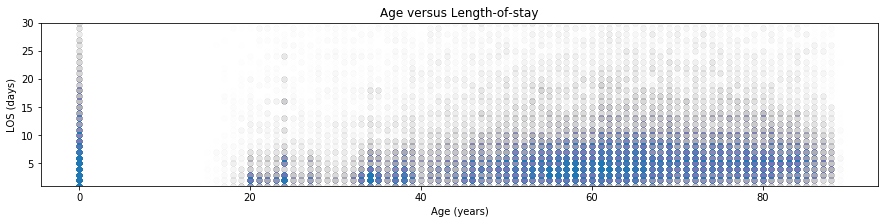

In [0]:
plt.figure(figsize=(15,3))
plt.scatter(df_pat['AGE'], df_pat['LOS'], alpha=0.005)
plt.ylabel('LOS (days)')
plt.xlabel('Age (years)')
plt.title('Age versus Length-of-stay')
plt.ylim(1, 30)

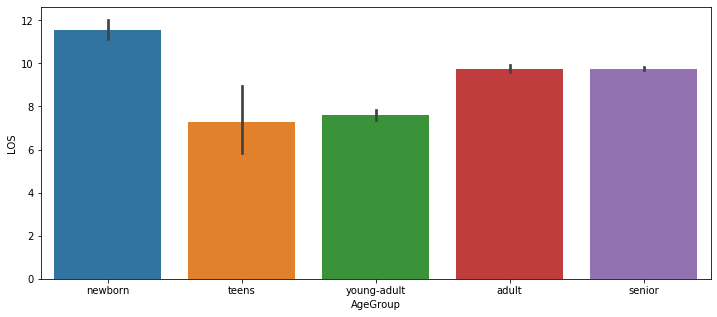

In [0]:
plt.figure(figsize=(12,5))
sns.barplot(x = df_pat['AgeGroup'], y = df_pat['LOS'])

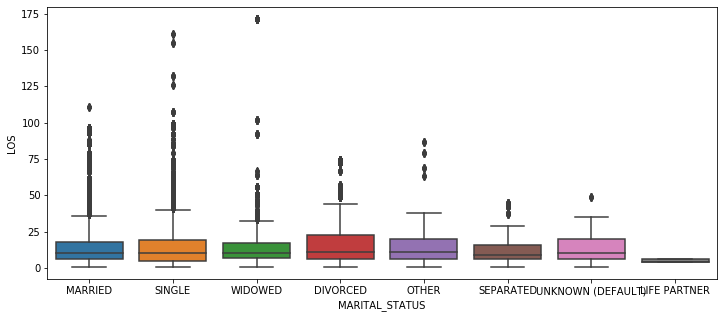

In [0]:
plt.figure(figsize=(12,5))
sns.boxplot(x = df['MARITAL_STATUS'], y = df['LOS'])

Text(0.5, 1.0, 'Top 30 Drugs Taken by Patients')

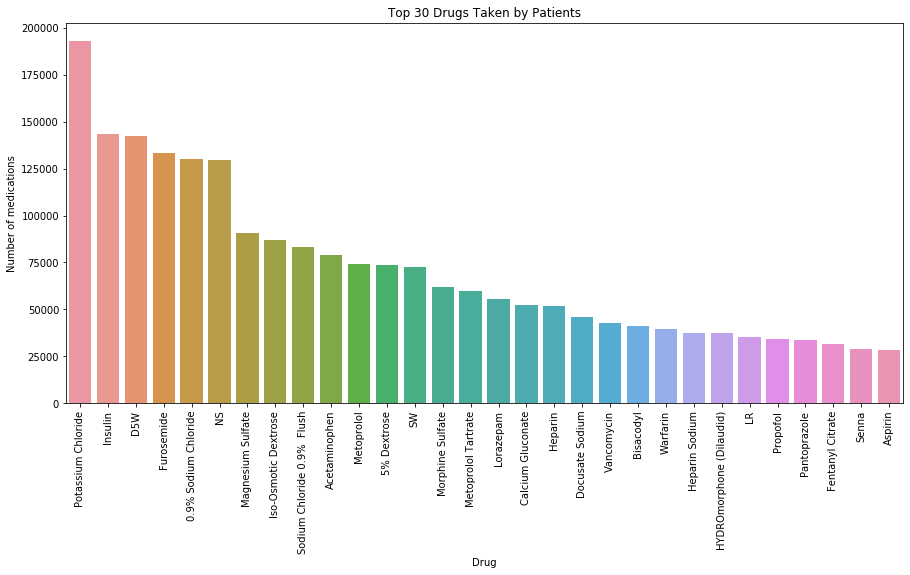

In [0]:
plt.figure(figsize=(15,7))
top_drug = df_drug['DRUG'].value_counts()[:30]
sns.barplot(top_drug.index, top_drug.values)
plt.xticks(rotation=90)
plt.xlabel('Drug')
plt.ylabel('Number of medications')
plt.title('Top 30 Drugs Taken by Patients')

In [0]:
results = df[['STOPPED', 'LOS']].groupby('STOPPED').median().reset_index()

In [0]:
categories = results['STOPPED'].values.tolist()

hist_data = []
for cat in categories:
    hist_data.append(df['LOS'].loc[df['STOPPED']==cat].values)
    
hist_data

[array([25, 25, 25, ..., 37, 37, 37]),
 array([17, 17, 17, ..., 37, 37, 37]),
 array([ 9,  9,  9, ..., 37, 37, 37]),
 array([13, 13, 13, ..., 37, 37, 37])]

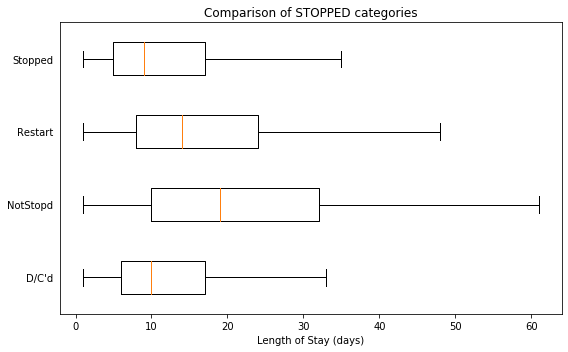

In [0]:
fig, ax = plt.subplots(figsize=(8,5))
ax.boxplot(hist_data, 0, '', vert=False)
ax.set_yticklabels(categories)
ax.set_xlabel('Length of Stay (days)')
ax.tick_params(left=False, right=False) 
ax.set_title('Comparison of {} categories'.format('STOPPED'))
plt.tight_layout()
plt.show()

In [0]:
df['LOS'].describe()

count    67505.000000
mean        14.875506
std         14.852362
min          1.000000
25%          6.000000
50%         10.000000
75%         18.000000
max        171.000000
Name: LOS, dtype: float64

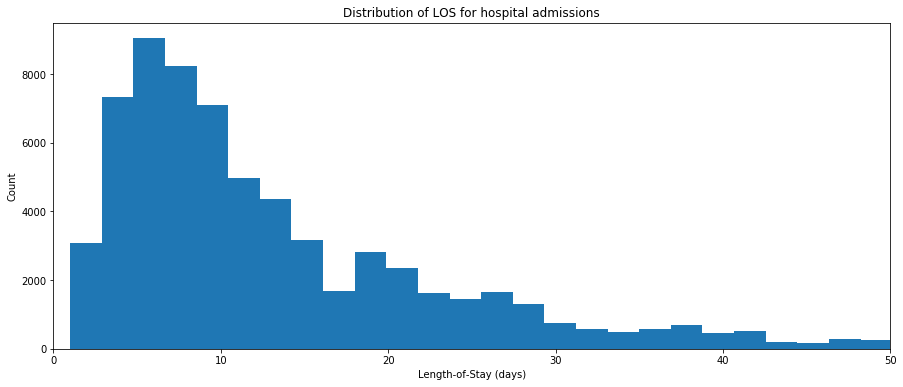

In [0]:
plt.figure(figsize=(15, 6))
plt.hist(df['LOS'], bins=90)
plt.xlim(0, 50)
plt.title('Distribution of LOS for hospital admissions')
plt.ylabel('Count')
plt.xlabel('Length-of-Stay (days)')
plt.tick_params(top=False, right=False) 
plt.show()

## 2. Prediction and Evaluation

### 2.1 Regression Model

I will use the Scikit-Learn machine learning library to implementation supervised learning prediction models.

In [0]:
df_clean = pd.read_csv('newdata/new_df.csv', index_col=0)

In [0]:
df_clean.head()

,ICUSTAY,DRUG,Num_CPT,REQUEST_TELE,REQUEST_RESP,REQUEST_CDIFF,REQUEST_MRSA,REQUEST_VRE,TRANSFERTIME,LOS,...,MARR_SEPARATED,MARR_SINGLE,MARR_UNKNOWN (DEFAULT),MARR_WIDOWED,ETH_ASIAN,ETH_BLACK/AFRICAN AMERICAN,ETH_HISPANIC OR LATINO,ETH_OTHER,ETH_UNKNOWN/NOT SPECIFIED,ETH_WHITE
0,6,91,4,0,0,0,0,0,2,25,...,0,0,0,0,0,0,0,0,0,1
1,6,91,4,0,0,0,0,0,2,25,...,0,0,0,0,0,0,0,0,0,1
2,6,91,4,0,0,0,0,0,2,25,...,0,0,0,0,0,0,0,0,0,1
3,6,91,4,0,0,0,0,0,2,25,...,0,0,0,0,0,0,0,0,0,1
4,6,91,4,0,0,0,0,0,2,25,...,0,0,0,0,0,0,0,0,0,1


I first define it as a regression problem, and use the mean square error as a metric.

The expected result of the project is to develop a model that will predict hospital LOS better than the industry median and average LOS. To measure the effect, I will use root mean square error (RMSE) to compare the prediction model with the median and average LOS.

<img src="images/RMSE.png" width='300'/>

The R-squared will be used to determine the best regression model.

<img src="images/r2.png" width="400"/>

In [0]:
# target 
LOS = df_clean['LOS'].values  # y
# features
features = df_clean.drop('LOS', axis=1) # X

X_train, X_test, y_train, y_test = train_test_split(features, LOS, test_size = 0.33)

In [0]:
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 45160 samples.
Testing set has 22243 samples.


In [0]:
# Regression models for comparison
models = [SGDRegressor(random_state = 0), 
          GradientBoostingRegressor(random_state = 0), 
          LinearRegression(),
          KNeighborsRegressor(),
          RandomForestRegressor(random_state = 0)]

In [0]:
results = {}
for model in models:
    reg_model = model
    reg_model.fit(X_train, y_train)
    y_preds = reg_model.predict(X_test)
    name = str(model).split("(")[0]
    results[name] = r2_score(y_test, y_preds)
    print('Regression Model: {}, R^2: {}'.format(name, r2_score(y_test, y_preds)))
    
print(results)

Regression Model: SGDRegressor, R^2: -3.9260424617847845e+23
Regression Model: GradientBoostingRegressor, R^2: 0.9063600573487613
Regression Model: LinearRegression, R^2: 0.7802898505760767
Regression Model: KNeighborsRegressor, R^2: 0.9923082498333268
Regression Model: RandomForestRegressor, R^2: 0.9992523680351909
{'SGDRegressor': -3.9260424617847845e+23, 'GradientBoostingRegressor': 0.9063600573487613, 'LinearRegression': 0.7802898505760767, 'KNeighborsRegressor': 0.9923082498333268, 'RandomForestRegressor': 0.9992523680351909}


In [0]:
sorted(results.items(), key=lambda x: x[1], reverse=True)[0]

('RandomForestRegressor', 0.9992523680351909)

In [0]:
# RandomForestRegressor has the highest R-square
reg_model = RandomForestRegressor(random_state = 0)
reg_model.fit(X_train, y_train)
y_preds = reg_model.predict(X_test)
r_square = r2_score(y_test, y_preds)

In [0]:
print('The R^2 is {:.2f}%'.format(r_square*100))

The R^2 is 99.93%


In [0]:
with open('newdata/reg_model', 'wb') as f:
    pickle.dump(reg_model, f)

In [0]:
with open('newdata/reg_model', 'rb') as f:
    reg_model = pickle.load(f)

In [0]:
y_preds = reg_model.predict(X_test)

In [0]:
y_pred_a = pd.DataFrame(y_preds)
y_test_a = pd.DataFrame(y_test)
pred_act_df = pd.concat([y_test_a, y_pred_a], axis=1).reset_index(drop=True)

In [0]:
pred_act_df.columns = ['Actual','Predict']

In [0]:
pred_act_df.head()

,Actual,Predict
0,6,6.06
1,16,15.99
2,6,5.97
3,7,7.10
4,15,15.00


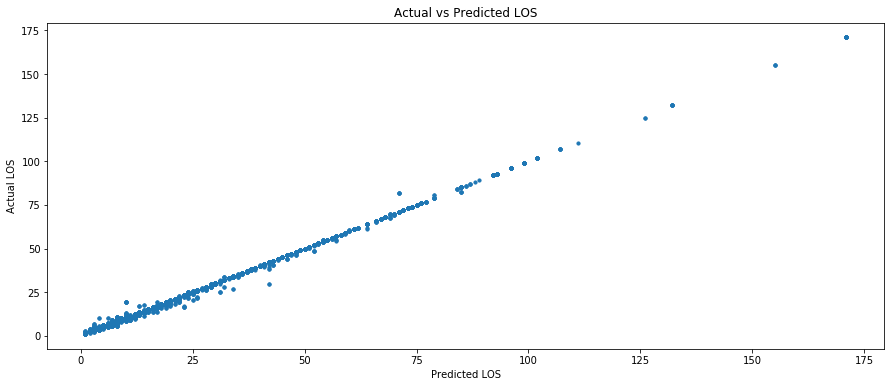

In [0]:
#output samples of our predicted values
plt.figure(figsize=(15, 6))
plt.scatter(pred_act_df['Actual'], pred_act_df['Predict'], s=10)
plt.xlabel('Predicted LOS')
plt.ylabel('Actual LOS')
plt.plot(ls="--", c=".3")
plt.title('Actual vs Predicted LOS')
plt.show()

### Feature Importance

In [0]:
feature_importance = []
for i, feature in enumerate(reg_model.feature_importances_):
    feature_importance.append((X_train.columns[i], feature))

# top 10 features
feature_importance = pd.DataFrame(sorted(feature_importance, key=lambda x: x[1], reverse = True))
feature_importance.columns = ['Features', 'Importance']
feature_importance[:10]

,Features,Importance
0,DRUG,0.730777
1,Num_CPT,0.136790
2,ICUSTAY,0.028921
3,Infectious Diseases,0.009280
4,Injury,0.007109
5,Digestive System,0.006824
6,Circulatory System,0.006735
7,Respiratory System,0.005521
8,Genitourinary System,0.004981
9,TRANSFERTIME,0.004773


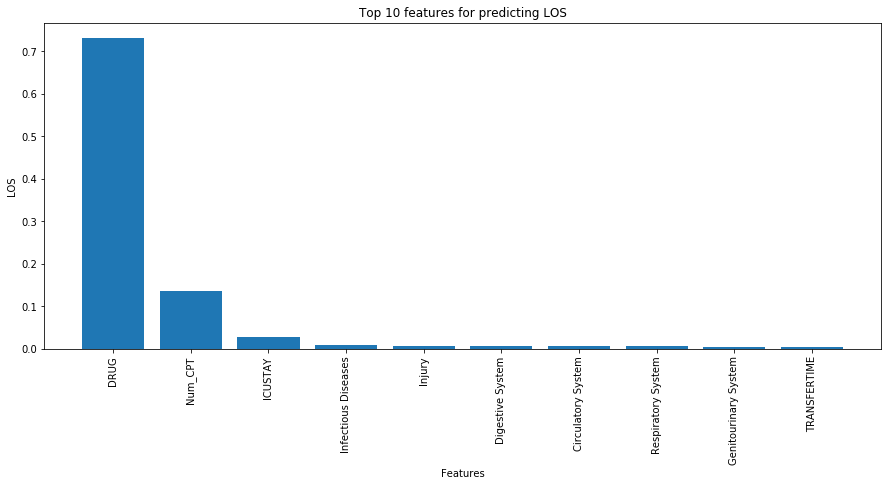

In [0]:
# plot
x = feature_importance['Features'][:10]
y = feature_importance['Importance'][:10]
plt.figure(figsize = (15, 6))
plt.bar(x, y)
plt.title('Top 10 features for predicting LOS')
plt.xlabel('Features')
plt.ylabel('LOS')
plt.xticks(rotation=90)
plt.show()

#### Compare with Mean and Median LOS

In [0]:
ml_model = 0
ml_median = 0
ml_ave = 0
for i in range(y_preds.shape[0]):
    ml_model_rms = np.power((y_preds[i] - y_test[i]), 2)
    ml_model += ml_model_rms
    median_model = np.power((median_los - y_test[i]), 2)
    ml_median += median_model
    average_model = np.power((mean_los - y_test[i]), 2)
    ml_ave += average_model

In [0]:
Regression_RMSE = ((ml_model ** 0.5)/y_preds.shape[0])*100
Median_RMSE = ((ml_median**0.5)/y_preds.shape[0])*100
Average_RMSE = ((ml_ave**0.5)/y_preds.shape[0])*100

In [0]:
print("Regression Model RMS {:.2f}%".format(Regression_RMSE))
print("Median Model RMS {:.2f}%".format(Median_RMSE))
print("Average Model RMS {:.2f}%".format(Average_RMSE))

Regression Model RMS 0.27%
Median Model RMS 11.64%
Average Model RMS 10.55%


In [0]:
RMSE = [Regression_RMSE, Median_RMSE, Average_RMSE]
x = ['Regression Model', 'Average', 'Median']

Text(0.5, 0, 'Model Type')

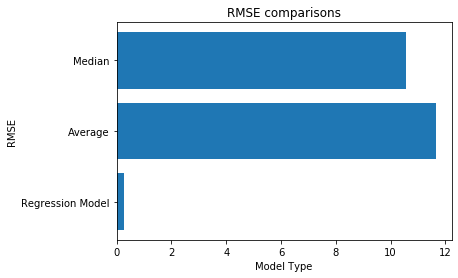

In [0]:
plt.barh(x, RMSE)
plt.title('RMSE comparisons')
plt.ylabel('RMSE')
plt.xlabel('Model Type')

### 2.2 Classification Model

I then frame it as a classification problem with 4 classes, one for ICU shorter than one day, one for less than one week, one for over one week but less than two weeks and one for stay over two weeks.

<img src="images/pre.png"/>

In [0]:
df_clean = pd.read_csv('/content/new_df.csv', index_col=0)

In [0]:
# target 
LOS = df_clean['LOS'].values  # y
# features
features = df_clean.drop('LOS', axis=1) # X

In [0]:
# frame to 4 classes
bins = [0, 4, 8, 15, 300]
labels = ['less than three day', 'three to one week', 'one to two weeks', 'more than two weeks']

y = pd.cut(LOS, bins=bins, labels=labels, right=False)

In [0]:
y.value_counts()

less than three day     6421
three to one week      17319
one to two weeks       20432
more than two weeks    23231
dtype: int64

In [0]:
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size = .33, random_state = 42)

In [0]:
# Compare different models
model_class = [RandomForestClassifier(), 
               KNeighborsClassifier(), 
               linear_model.SGDClassifier(), 
               GaussianNB()]

In [0]:
for model in model_class:
    class_model = model
    class_model.fit(X_train, y_train)
    
    y_preds = class_model.predict(X_test)
    
    name = str(model).split("(")[0]
    
    conf_mx = confusion_matrix(y_test, y_preds)

    recall = np.mean(np.diag(conf_mx) / np.sum(conf_mx, axis = 1))*100
    precision = np.mean(np.diag(conf_mx) / np.sum(conf_mx, axis = 0))*100
    accuracy = (np.sum(np.diag(conf_mx)) / np.sum(conf_mx))*100
    
    print('Classification Model: {}, Recall: {:.2f}%, Precision: {:.2f}%, Accuracy: {:.2f}%'.format(name, recall, precision, accuracy))

Classification Model: RandomForestClassifier, Recall: 99.81%, Precision: 99.88%, Accuracy: 99.89%
Classification Model: KNeighborsClassifier, Recall: 95.79%, Precision: 95.51%, Accuracy: 96.38%
Classification Model: SGDClassifier, Recall: 65.74%, Precision: 66.43%, Accuracy: 64.52%
Classification Model: GaussianNB, Recall: 62.03%, Precision: 57.91%, Accuracy: 59.44%


In [0]:
class_model = RandomForestClassifier()

In [0]:
class_model.fit(X_train, y_train)
y_preds = class_model.predict(X_test)

In [0]:
with open('newdata/class_model', 'wb') as f:
    pickle.dump(class_model, f)

In [0]:
with open('newdata/class_model', 'rb') as f:
    class_model = pickle.load(f)

In [0]:
conf_mx = confusion_matrix(y_test, y_preds)

In [9]:
conf_mx

array([[2138,    0,    0,   12],
       [   0, 7645,    6,    0],
       [   0,    3, 6730,    8],
       [   6,    0,    4, 5691]])

In [0]:
recall = np.mean(np.diag(conf_mx) / np.sum(conf_mx, axis = 1))*100
precision = np.mean(np.diag(conf_mx) / np.sum(conf_mx, axis = 0))*100
accuracy = (np.sum(np.diag(conf_mx)) / np.sum(conf_mx))*100

In [11]:
print('Classification Model: RandomForestClassifier, Recall: {:.2f}%, Precision: {:.2f}%, Accuracy: {:.2f}%'.format(recall, precision, accuracy))

Classification Model: RandomForestClassifier, Recall: 99.76%, Precision: 99.80%, Accuracy: 99.82%


In [12]:
print(classification_report(y_test,y_preds))

                     precision    recall  f1-score   support

less than three day       1.00      0.99      1.00      2150
more than two weeks       1.00      1.00      1.00      7651
   one to two weeks       1.00      1.00      1.00      6741
  three to one week       1.00      1.00      1.00      5701

           accuracy                           1.00     22243
          macro avg       1.00      1.00      1.00     22243
       weighted avg       1.00      1.00      1.00     22243



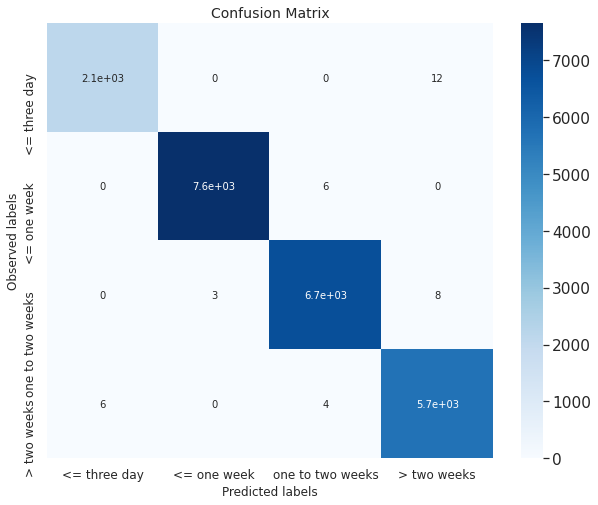

In [15]:
plt.figure(figsize=(10,8))
ax = plt.subplot()
sns.set(font_scale=1.4) # Adjust to fit
sns.heatmap(conf_mx, ax=ax, cmap="Blues", annot = True, annot_kws={"size": 10});  

# Labels, title and ticks
label_font = {'size':'12'}  # Adjust to fit
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('Observed labels', fontdict=label_font);

title_font = {'size':'14'}  # Adjust to fit
ax.set_title('Confusion Matrix', fontdict=title_font);

ax.tick_params(axis='both', which='major', labelsize=12)  # Adjust to fit
ax.xaxis.set_ticklabels(['<= three day', '<= one week', 'one to two weeks', '> two weeks']);
ax.yaxis.set_ticklabels(['<= three day', '<= one week', 'one to two weeks', '> two weeks']);
plt.show()

In [0]:
feature_importance = []
for i, feature in enumerate(class_model.feature_importances_):
    feature_importance.append((X_train.columns[i], feature))

# top 10 features
feature_importance = pd.DataFrame(sorted(feature_importance, key=lambda x: x[1], reverse = True))
feature_importance.columns = ['Features', 'Importance']
feature_importance[:10]

,Features,Importance
0,DRUG,0.208575
1,Num_CPT,0.138877
2,ICUSTAY,0.121925
3,Injury,0.033926
4,Circulatory System,0.032167
5,Respiratory System,0.028055
6,"Endocrine, Immunity Disorders",0.023524
7,Digestive System,0.023435
8,TRANSFERTIME,0.022021
9,Genitourinary System,0.019176


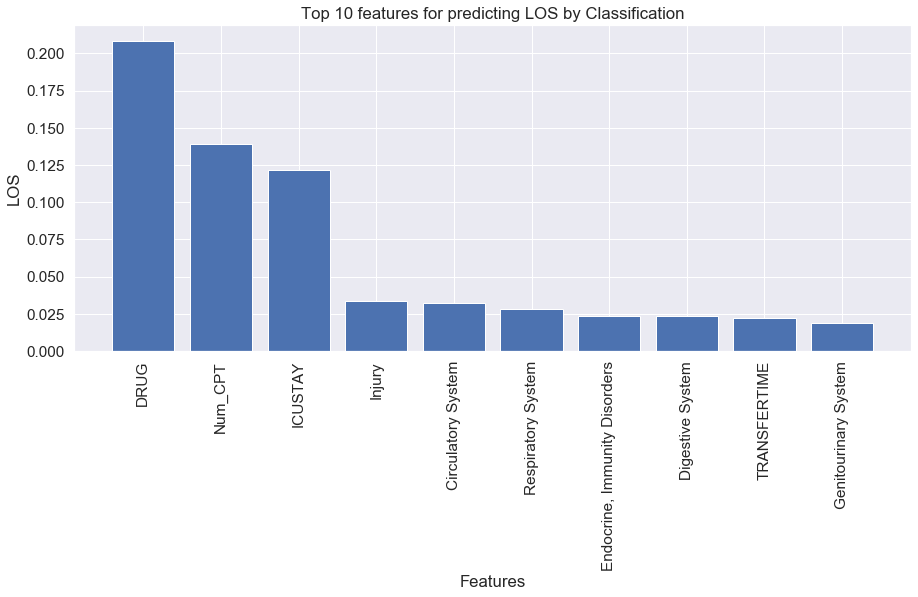

In [0]:
# plot
x = feature_importance['Features'][:10]
y = feature_importance['Importance'][:10]
plt.figure(figsize = (15, 6))
plt.bar(x, y)
plt.title('Top 10 features for predicting LOS by Classification')
plt.xlabel('Features')
plt.ylabel('LOS')
plt.xticks(rotation=90)
plt.show()

### 2.3 RNN LSTM

In [4]:
df_clean = pd.read_csv('newdata/new_df.csv', index_col=0)

In [0]:
# target 
LOS = df_clean['LOS'].values  # y
# features
features = df_clean.drop('LOS', axis=1) # X

# frame to 4 classes
bins = [0, 4, 8, 15, 300]
labels = ['less than three day', 'three to one week', 'one to two weeks', 'more than two weeks']

df_clean['LOS'] = pd.cut(LOS, bins=bins, labels=labels, right=False)

In [0]:
df_clean['LOS'].value_counts()

more than two weeks    23306
one to two weeks       20447
three to one week      17331
less than three day     6421
Name: LOS, dtype: int64

In [0]:
# make balanced classes
# avoid underfitting
shuffled = df_clean.reindex(np.random.permutation(df_clean.index))
one_week = shuffled[shuffled['LOS'] == 'three to one week'][:10000]
one_two = shuffled[shuffled['LOS'] == 'one to two weeks'][:13000]
two_more = shuffled[shuffled['LOS'] == 'more than two weeks'][:13000]
three_day = shuffled[shuffled['LOS'] == 'less than three day']
concated = pd.concat([three_day, one_week, one_two, two_more], ignore_index=True)

In [0]:
le = LabelEncoder()
labels = le.fit_transform(concated['LOS'])

In [0]:
labels = to_categorical(labels, num_classes=4)

In [0]:
labels

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]], dtype=float32)

In [0]:
X = concated.drop('LOS', axis=1)
X = X.iloc[:, 1:]
X.head()

,DRUG,GSN,CPT_CD,REQUEST_TELE,REQUEST_RESP,REQUEST_CDIFF,REQUEST_MRSA,REQUEST_VRE,TRANSFERTIME,blood diseases,circulatory system,complications of pregnancy,congenital anomalies,digestive system,"endocrine,immunity disorders",genitourinary system,infectious diseases,injury,mental disorders,musculoskeletal system,neoplasms,nervous system and sense organs,perinatal period,respiratory system,skin and subcutaneous tissue,"symptoms,ill-defined conditions",STOP_D/C'd,STOP_NotStopd,STOP_Restart,STOP_Stopped,EVEN_admit,EVEN_discharge,EVEN_transfer,SER_CMED,SER_CSURG,SER_DENT,SER_ENT,SER_GU,SER_GYN,SER_MED,...,SER_SURG,SER_TRAUM,SER_TSURG,SER_VSURG,CARE_ICU,AGE_newborn,AGE_teens,AGE_young-adult,AGE_adult,AGE_senior,DB_carevue,DB_carevue & metavision,DB_metavision,GENDER_F,GENDER_M,INSUR_Government,INSUR_Medicaid,INSUR_Medicare,INSUR_Private,INSUR_Self Pay,RELI_CATHOLIC,RELI_JEWISH,RELI_NOT SPECIFIED,RELI_OTHER,RELI_PROTESTANT QUAKER,RELI_UNOBTAINABLE,MARR_DIVORCED,MARR_LIFE PARTNER,MARR_MARRIED,MARR_OTHER,MARR_SEPARATED,MARR_SINGLE,MARR_UNKNOWN (DEFAULT),MARR_WIDOWED,ETH_ASIAN,ETH_BLACK/AFRICAN AMERICAN,ETH_HISPANIC OR LATINO,ETH_OTHER,ETH_UNKNOWN/NOT SPECIFIED,ETH_WHITE
0,27,24,4,0,0,0,0,0,1,0,2,0,0,0,1,1,1,1,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
1,5,5,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0
2,39,34,5,0,0,0,0,0,1,0,0,0,0,0,1,0,0,2,2,0,0,0,0,2,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
3,11,9,5,0,0,0,0,0,1,1,1,0,0,1,1,0,0,3,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
4,32,29,3,1,0,0,0,0,1,0,3,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size = .33, random_state = 42)

In [0]:
epochs = 100
batch_size = 256

In [0]:
# Use of DROPOUT to avoid over fitting
model = Sequential()
model.add(Dense(2048, activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(X.shape[1],)))
model.add(Dense(2048, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(2048, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

model.compile(optimizer=optimizers.Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])


# model = Sequential()
# model.add(Embedding(100000, 128, input_length=features.shape[1]))
# model.add(LSTM(128, dropout=0.8, recurrent_dropout=0.8))
# model.add(Dense(4, activation='softmax'))
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 2048)              180224    
_________________________________________________________________
dense_5 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 8196      
Total params: 8,581,124
Trainable params: 8,581,124
Non-trainable params: 0
____________________________________________

In [0]:
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/100
112/112 [==============================] - 1s 12ms/step - loss: 7.1443 - accuracy: 0.3175 - val_loss: 5.3929 - val_accuracy: 0.3955
Epoch 2/100
112/112 [==============================] - 1s 10ms/step - loss: 5.8886 - accuracy: 0.3642 - val_loss: 5.0013 - val_accuracy: 0.4442
Epoch 3/100
112/112 [==============================] - 1s 10ms/step - loss: 5.2319 - accuracy: 0.4096 - val_loss: 4.7365 - val_accuracy: 0.4877
Epoch 4/100
112/112 [==============================] - 1s 10ms/step - loss: 4.8282 - accuracy: 0.4597 - val_loss: 4.4919 - val_accuracy: 0.5921
Epoch 5/100
112/112 [==============================] - 1s 10ms/step - loss: 4.5329 - accuracy: 0.5170 - val_loss: 4.3059 - val_accuracy: 0.6171
Epoch 6/100
112/112 [==============================] - 1s 10ms/step - loss: 4.3100 - accuracy: 0.5624 - val_loss: 4.1334 - val_accuracy: 0.6408
Epoch 7/100
112/112 [==============================] - 1s 10ms/step - loss: 4.1315 - accuracy: 0.5874 - val_loss: 3.9853 - val_accuracy:

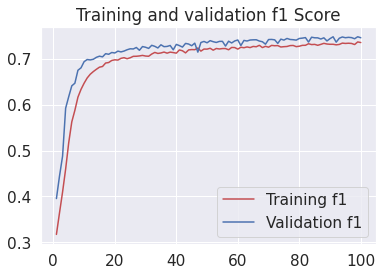

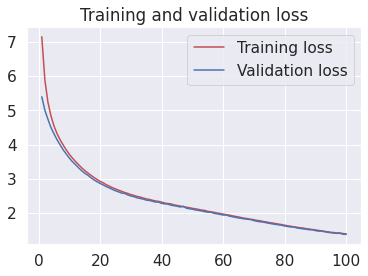

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training f1')
plt.plot(epochs, val_acc, 'b', label='Validation f1')
plt.title('Training and validation f1 Score')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
model.save('/content/los.h5')

In [0]:
model = load_model('/content/los.h5')

In [0]:
predictions = model.predict(X_test)

In [0]:
idx = np.argmax(predictions, axis=-1)
predictions = np.zeros(predictions.shape)
predictions[np.arange(predictions.shape[0]), idx] = 1

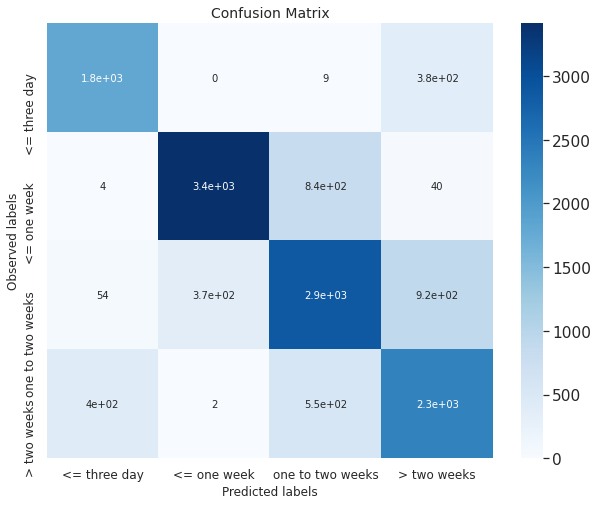

In [0]:
conf_mx = confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))
plt.figure(figsize=(10,8))
ax = plt.subplot()
sns.set(font_scale=1.4) # Adjust to fit
sns.heatmap(conf_mx, ax=ax, cmap="Blues", annot = True, annot_kws={"size": 10});  

# Labels, title and ticks
label_font = {'size':'12'}  # Adjust to fit
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('Observed labels', fontdict=label_font);

title_font = {'size':'14'}  # Adjust to fit
ax.set_title('Confusion Matrix', fontdict=title_font);

ax.tick_params(axis='both', which='major', labelsize=12)  # Adjust to fit
ax.xaxis.set_ticklabels(['<= three day', '<= one week', 'one to two weeks', '> two weeks']);
ax.yaxis.set_ticklabels(['<= three day', '<= one week', 'one to two weeks', '> two weeks']);
plt.show()

In [0]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

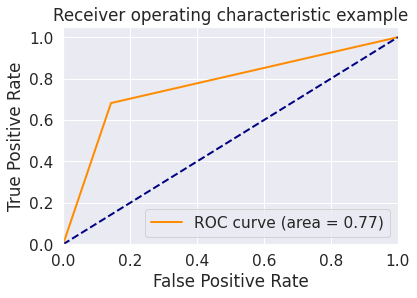

In [0]:
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [0]:
conf_mx = confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))

In [0]:
recall = np.mean(np.diag(conf_mx) / np.sum(conf_mx, axis = 1))*100
precision = np.mean(np.diag(conf_mx) / np.sum(conf_mx, axis = 0))*100
accuracy = (np.sum(np.diag(conf_mx)) / np.sum(conf_mx))*100

In [0]:
print('Recall: {:.2f}%, Precision: {:.2f}%, Accuracy: {:.2f}%'.format(recall, precision, accuracy))

Recall: 75.26%, Precision: 75.21%, Accuracy: 74.53%


# 3. Predict New Admission

In [3]:
new_df = pd.read_csv('newdata/new_df.csv', index_col = 0)

In [52]:
lst1 = pd.DataFrame([], columns = ['ICUSTAY_ID'])
ICUSTAY_ID = input('Enter ICUSTAY days: ')
lst1 = lst1.append({'ICUSTAY_ID': int(ICUSTAY_ID)}, ignore_index=True)

lst2 = pd.DataFrame([], columns = ['DRUG'])
d = input('Enter DRUG number: ')
lst2 = lst2.append({'DRUG': int(d)}, ignore_index=True)

lst4 = pd.DataFrame([], columns = ['Num_CPT'])
c = input('Enter CPT number: ')
lst4 = lst4.append({'Num_CPT': int(c)}, ignore_index=True)

a = np.zeros(shape=(1,5))
lst5 = pd.DataFrame([], columns = ["REQUEST_TELE", 'REQUEST_RESP', 'REQUEST_CDIFF', 'REQUEST_MRSA', 'REQUEST_VRE'])
g = input("Enter STOPPED type ('TELE', 'RESP', 'CDIFF', 'MRSA', 'VRE', 'None'): ")
if g != 'None':
    lst5 = lst5.append({'REQUEST_{}'.format(str(g)): int(1)}, ignore_index=True)
else:
    lst5 = pd.DataFrame(a, columns = ["REQUEST_TELE", 'REQUEST_RESP', 'REQUEST_CDIFF', 'REQUEST_MRSA', 'REQUEST_VRE'])

lst6 = pd.DataFrame([], columns = ['TRANSFERTIME'])
g = input('Enter TRANSFERTIME: ')
lst6 = lst6.append({'TRANSFERTIME': int(g)}, ignore_index=True)   


a = np.zeros(shape=(1,17))
col = ['Blood Diseases', 'Circulatory System', 'Congenital Anomalies',
       'Digestive System', 'Endocrine, Immunity Disorders',
       'Genitourinary System', 'Infectious Diseases', 'Injury',
       'Mental Disorders', 'Musculoskeletal System', 'Neoplasms',
       'Nervous System', 'Perinatal Period', 'Pregnancy', 'Respiratory System',
       'Skin and Subcutaneous Tissue', 'Symptoms Conditions']
lst7 = pd.DataFrame([], columns = col)
g = input("""Enter one of the ICD9 diagnosis, if more than one, split by '&', no space between, follow the number in ':' 
        'Blood Diseases', 'Circulatory System', 
        'Congenital Anomalies','Digestive System', 
        'Endocrine, Immunity Disorders',
       'Genitourinary System', 'Infectious Diseases',
       'Injury', 'Mental Disorders', 'Musculoskeletal System', 
       'Neoplasms', 'Nervous System', 'Perinatal Period', 
       'Pregnancy', 'Respiratory System',
       'Skin and Subcutaneous Tissue', 'Symptoms Conditions', 'None': """)
if g != 'None':
    if '&' in g:
        k = g.split('&')
        for i in k:
            j = i.split(':')
            lst7 = lst7.append({'{}'.format(str(j[0])): int(j[1])}, ignore_index=True)
        lst7 = lst7.max().to_frame().T
    else:
        lst7 = lst7.append({'{}'.format(str(g)): int(1)}, ignore_index=True)
else:
    lst7 = pd.DataFrame(a, columns = col)


lst8 = pd.DataFrame([], columns = ["STOP_D/C'd", 'STOP_NotStopd', 'STOP_Restart', 'STOP_Stopped'])
g = input("Enter STOPPED type (D/C'd, NotStopd, Restart,Stopped): ")
lst8 = lst8.append({'STOP_{}'.format(str(g)): int(1)}, ignore_index=True)


lst9 = pd.DataFrame([], columns = ['EVEN_admit', 'EVEN_discharge', 'EVEN_transfer'])
g = input("Enter EVEN type ('admit', 'discharge', 'transfer'): ")
lst9 = lst9.append({'EVEN_{}'.format(str(g)): int(1)}, ignore_index=True)


cols = ['SER_CMED', 'SER_CSURG', 'SER_MED',
       'SER_NMED', 'SER_NSURG', 'SER_OMED', 'SER_OTHER', 'SER_SURG',
       'SER_TRAUM', 'SER_VSURG']
lst10 = pd.DataFrame([], columns = cols)
g = input("""Enter Service type ('CMED', 'CSURG', 'MED',
       'NMED', 'NSURG', 'OMED', 'OTHER', 'SURG',
       'TRAUM', 'VSURG'): """)
lst10 = lst10.append({'SER_{}'.format(str(g)): int(1)}, ignore_index=True)

lsticu = pd.DataFrame([], columns = ['CARE_ICU'])
g = input('Enter CARE_ICU number: ')
lsticu = lsticu.append({'CARE_ICU': int(g)}, ignore_index=True)  

lst11 = pd.DataFrame([], columns = ['AGE_newborn', 'AGE_teens', 'AGE_young-adult', 'AGE_adult', 'AGE_senior'])
g = input("Enter Age ('newborn', 'teens', 'young-adult', 'adult', 'senior'): ")
lst11 = lst11.append({'AGE_{}'.format(str(g)): int(1)}, ignore_index=True)

lst12 = pd.DataFrame([], columns = ['DB_carevue',
       'DB_carevue & metavision', 'DB_metavision'])
g = input("Enter DB type ('carevue', 'carevue & metavision', 'metavision'): ")
lst12 = lst12.append({'DB_{}'.format(str(g)): int(1)}, ignore_index=True)

lst13 = pd.DataFrame([], columns = ['GENDER_F', 'GENDER_M'])
g = input("Enter Gender ('F', 'M'): ")
lst13 = lst13.append({'GENDER_{}'.format(str(g)): int(1)}, ignore_index=True)

lst14 = pd.DataFrame([], columns = ['INSUR_Government', 'INSUR_Medicaid', 'INSUR_Medicare', 'INSUR_Private',
       'INSUR_Self Pay'])
g = input("Enter Insurance Type ('Government', 'Medicaid', 'Medicare', 'Private', 'Self Pay'): ")
lst14 = lst14.append({'INSUR_{}'.format(str(g)): int(1)}, ignore_index=True)

lst15 = pd.DataFrame([], columns = ['RELI_CATHOLIC', 'RELI_JEWISH', 'RELI_NOT SPECIFIED',
       'RELI_OTHER', 'RELI_PROTESTANT QUAKER', 'RELI_UNOBTAINABLE'])
g = input("Enter Religion Type ('NOT SPECIFIED', 'CATHOLIC', 'JEWISH', 'PROTESTANT QUAKER','UNOBTAINABLE', 'OTHER'): ")
lst15 = lst15.append({'RELI_{}'.format(str(g)): int(1)}, ignore_index=True)

lst16 = pd.DataFrame([], columns = ['MARR_DIVORCED', 'MARR_LIFE PARTNER', 'MARR_MARRIED', 'MARR_OTHER',
       'MARR_SEPARATED', 'MARR_SINGLE', 'MARR_UNKNOWN (DEFAULT)',
       'MARR_WIDOWED'])
g = input("""Enter Marriage ('OTHER', DIVORCED', 'LIFE PARTNER', 
          'MARRIED', 'SEPARATED', 'SINGLE', 'WIDOWED',
          'UNKNOWN (DEFAULT)'): """)
lst16 = lst16.append({'MARR_{}'.format(str(g)): int(1)}, ignore_index=True)

lst17 = pd.DataFrame([], columns = ['ETH_ASIAN', 'ETH_BLACK/AFRICAN AMERICAN', 
       'ETH_HISPANIC OR LATINO', 'ETH_OTHER', 'ETH_UNKNOWN/NOT SPECIFIED',
       'ETH_WHITE'])
g = input("Enter Ethnicity Type (ASIAN,BLACK/AFRICAN AMERICAN,HISPANIC OR LATINO,WHITE, OTHER, UNKNOWN/NOT SPECIFIED): ")
lst17 = lst17.append({'ETH_{}'.format(str(g)): int(1)}, ignore_index=True)


Enter ICUSTAY days: 394
Enter DRUG number: 205
Enter CPT number: 63
Enter STOPPED type ('TELE', 'RESP', 'CDIFF', 'MRSA', 'VRE', 'None'): TELE
Enter TRANSFERTIME: 1
Enter one of the ICD9 diagnosis, if more than one, split by '&', no space between, follow the number in ':' 
        'Blood Diseases', 'Circulatory System', 
        'Congenital Anomalies','Digestive System', 
        'Endocrine, Immunity Disorders',
       'Genitourinary System', 'Infectious Diseases',
       'Injury', 'Mental Disorders', 'Musculoskeletal System', 
       'Neoplasms', 'Nervous System', 'Perinatal Period', 
       'Pregnancy', 'Respiratory System',
       'Skin and Subcutaneous Tissue', 'Symptoms Conditions', 'None': Endocrine, Immunity Disorders:2&Injury:4&Nervous System:2&Respiratory System:3&Skin and Subcutaneous Tissue:3
Enter STOPPED type (D/C'd, NotStopd, Restart,Stopped): Restart
Enter EVEN type ('admit', 'discharge', 'transfer'): discharge
Enter Service type ('CMED', 'CSURG', 'MED',
       'NMED', 'N

In [53]:
df_test = pd.concat([lst1,lst2,lst4,lst5,lst6,lst7,lst8,lst9,lst10,lsticu,lst11,lst12,lst13,lst14,lst15,lst16,lst17], axis=1)

In [54]:
df_test = df_test.fillna(0)

In [55]:
df_test.values #Endocrine, Immunity Disorders:2&Injury:4&Nervous System:2&Respiratory System:3&Skin and Subcutaneous Tissue:3

array([[394., 205.,  63.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   2.,   0.,   0.,   4.,   0.,   0.,   0.,   2.,   0.,
          0.,   3.,   3.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,
          0.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.]])

In [56]:
# By Regression:
with open('newdata/reg_model', 'rb') as f:
    reg_model = pickle.load(f)

In [57]:
pred = reg_model.predict(df_test)

In [58]:
pred

array([35.97])

In [59]:
# By Classification:
with open('newdata/class_model', 'rb') as f:
    class_model = pickle.load(f)

In [60]:
pred_class = class_model.predict(df_test)

In [61]:
pred_class

array(['more than two weeks'], dtype=object)

In [62]:
pd.set_option('display.max_columns', None)
first = new_df.tail(1)

In [63]:
first

,ICUSTAY,DRUG,Num_CPT,REQUEST_TELE,REQUEST_RESP,REQUEST_CDIFF,REQUEST_MRSA,REQUEST_VRE,TRANSFERTIME,LOS,Blood Diseases,Circulatory System,Congenital Anomalies,Digestive System,"Endocrine, Immunity Disorders",Genitourinary System,Infectious Diseases,Injury,Mental Disorders,Musculoskeletal System,Neoplasms,Nervous System,Perinatal Period,Pregnancy,Respiratory System,Skin and Subcutaneous Tissue,Symptoms Conditions,STOP_D/C'd,STOP_NotStopd,STOP_Restart,STOP_Stopped,EVEN_admit,EVEN_discharge,EVEN_transfer,SER_CMED,SER_CSURG,SER_MED,SER_NMED,SER_NSURG,SER_OMED,SER_OTHER,SER_SURG,SER_TRAUM,SER_VSURG,CARE_ICU,AGE_newborn,AGE_teens,AGE_young-adult,AGE_adult,AGE_senior,DB_carevue,DB_carevue & metavision,DB_metavision,GENDER_F,GENDER_M,INSUR_Government,INSUR_Medicaid,INSUR_Medicare,INSUR_Private,INSUR_Self Pay,RELI_CATHOLIC,RELI_JEWISH,RELI_NOT SPECIFIED,RELI_OTHER,RELI_PROTESTANT QUAKER,RELI_UNOBTAINABLE,MARR_DIVORCED,MARR_LIFE PARTNER,MARR_MARRIED,MARR_OTHER,MARR_SEPARATED,MARR_SINGLE,MARR_UNKNOWN (DEFAULT),MARR_WIDOWED,ETH_ASIAN,ETH_BLACK/AFRICAN AMERICAN,ETH_HISPANIC OR LATINO,ETH_OTHER,ETH_UNKNOWN/NOT SPECIFIED,ETH_WHITE
67402,394,205,63,1,1,0,0,0,1,37,0,1,0,0,2,0,0,4,0,0,0,2,0,0,3,3,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1


In [64]:
actual = first['LOS']
actual

67402    37
Name: LOS, dtype: int64

### Predict LOS vs Actual LOS

In [76]:
print('Predict LOS is {} days, Predict LOS class is {}.'.format(round(float(pred)), str(pred_class)))

Predict LOS is 36 days, Predict LOS class is ['more than two weeks'].


In [77]:
print('Actual LOS is {} days.'.format(int(actual)))

Actual LOS is 37 days.


In [78]:
print('Accuracy is {:.2f}%.'.format(100 *int(pred)/int(actual)))

Accuracy is 94.59%.
